In [1]:
# unzip the uploaded data into Google Drive
#!unzip "/content/drive/MyDrive/Dog Vision/dog-breed-identification_2.zip" -d "drive/MyDrive/Dog Vision/"

## End-to-End Multiclass Dog Breed Classification

This notebook builds an end-to-end multiclass image classifier using TensorFlow2.0 and Tensorflow Hub

## 1. Problem
Identifying the breed of a dog given the image of a dog.

## 2. Data
The data we're using is from kaggle's dog breed identification competition.

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features
Some information about the data:
* We're dealing with images(unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dog(this means that there are 120 different classes).
* There are around 10000 images in the training set and 10000+ images in the test set. The training set has labels, the test set does not have labels

### Get our workspace ready

* Import TensorFlow
* Import TensorFlow Hub
* Make sure you're using a GPU

In [2]:
# Import TensorFlow into colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.12.0
TF Hub version: 0.14.0
GPU available


## Getting our data ready(Turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors(numerical representations).

**To see a list of all short cuts in colab, hold ctrl+ M + H**

In [3]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

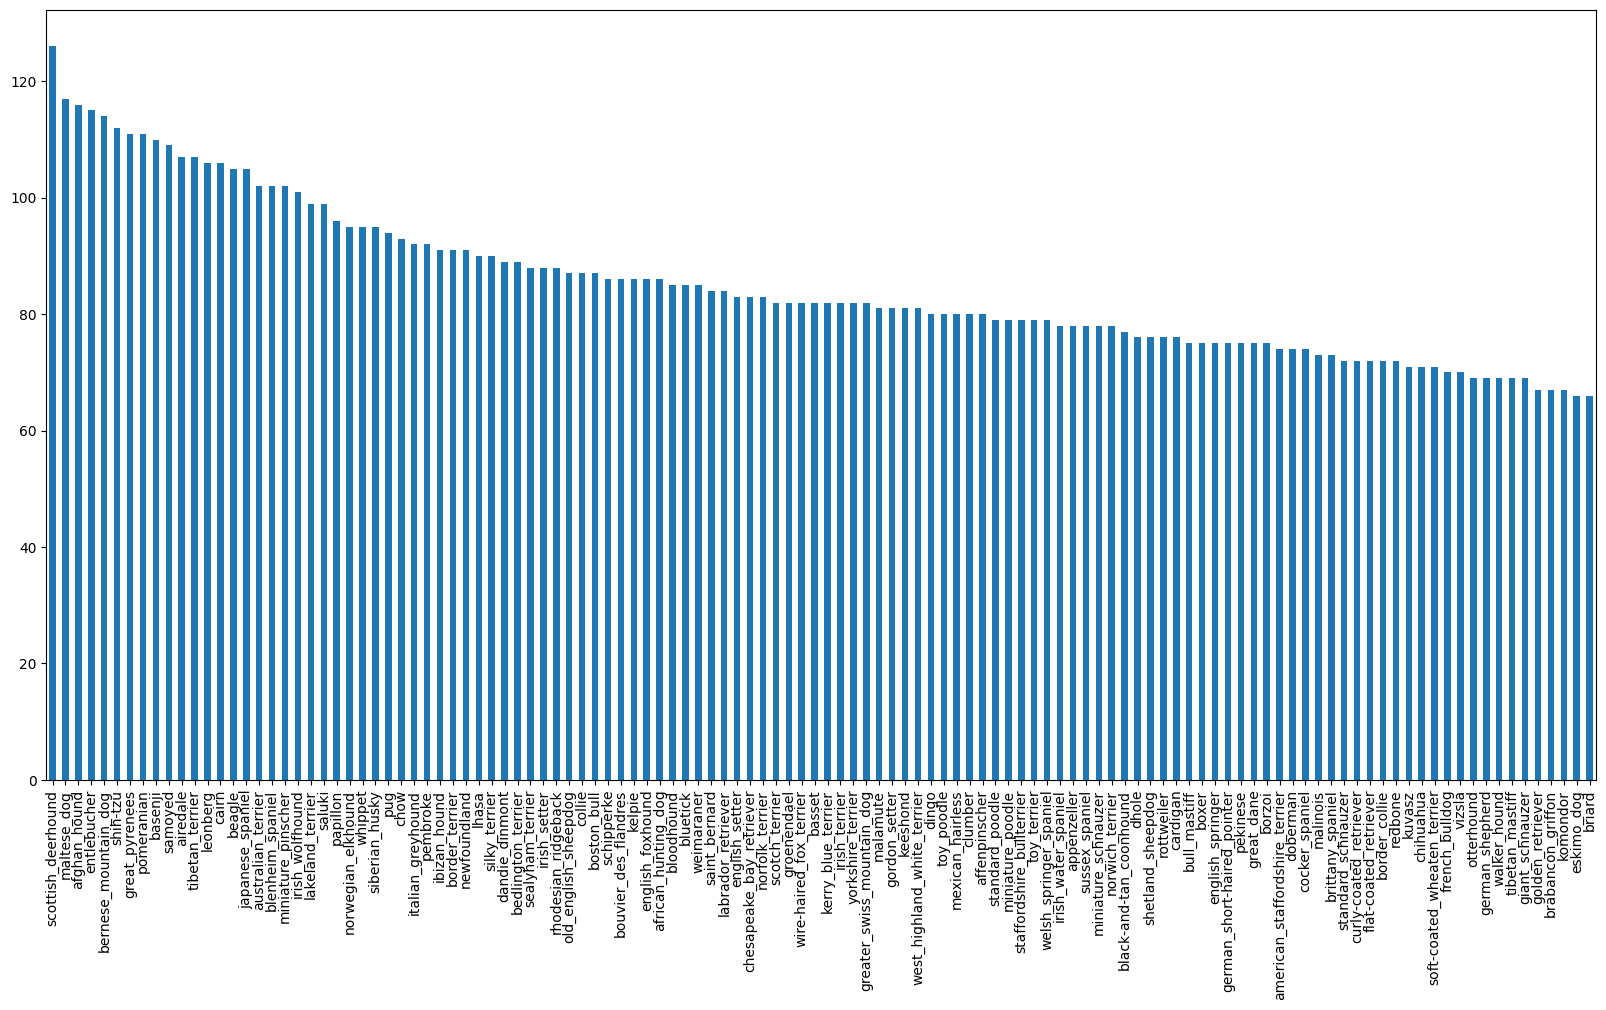

In [5]:
# How many images are there of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [6]:
labels_csv["breed"].value_counts().median()

82.0

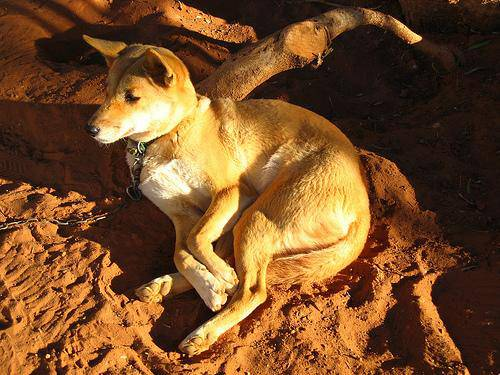

In [7]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all our image file pathnames.

In [8]:
# create pathnames from image ID's
filenames = ["drive/MyDrive/Dog Vision/train/"+ fname + ".jpg" for fname in labels_csv["id"]]

# check the first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [9]:
# Check whether number of filenames matches number of image files
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files")
else:
  print("Filenames do not match the actual amount of files.")

Filenames match actual amount of files


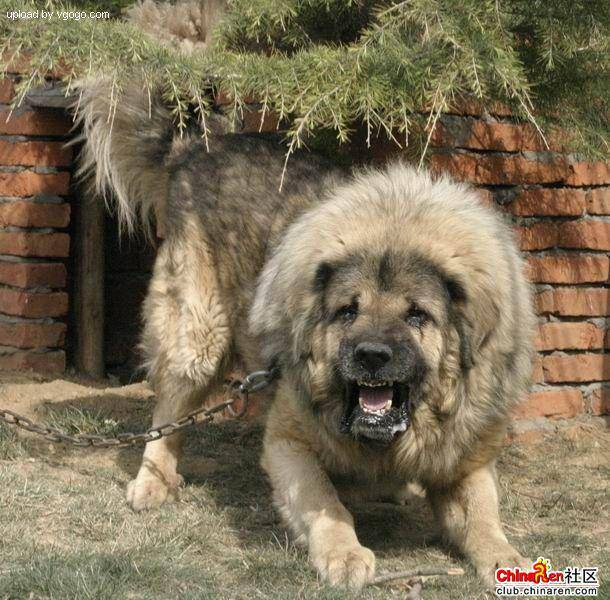

In [10]:
# one more check
Image(filenames[9000])

In [11]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) does the same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:
# see if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("number of labels matches number of filenames")
else:
  print("does not match")

number of labels matches number of filenames


In [13]:
# Find the unique labels
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [14]:
len(unique_breeds)

120

In [15]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# Turn every label into a boolean array
boolean_labels = [label== unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [17]:
len(boolean_labels)

10222

In [18]:
print(labels[0])
print(np.where(unique_breeds==labels[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own Validation Set

Since the data from kaggle doesn't come with a validation set, we're going to be creating our own

In [19]:
# set up X and y variables
X = filenames
y = boolean_labels

We're going to start off experimenting with 1000 images and increase as needed

In [20]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max:10000, step:1000}

In [21]:
# Let's split our data into training and validation sets
from sklearn.model_selection import train_test_split

# split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [22]:
# Let's have a quick look at the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## Preprocessing Images(Turning images into tensors)

To preprocess our images into tensors, we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` into Tensors
4. Normalize our image(convert colour channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224,224).
6. Return the modified `image`

Before we do, let's see what importing an image looks like

### Some useful links to help you understand loading of data into TensorFlow:
* https://www.tensorflow.org/tutorials/load_data/images
* https://www.tensorflow.org/guide/data

In [23]:
# Convert image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [24]:
image

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]

In [25]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [26]:
# turn image into Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, now we can write a function to preprocess them

In [27]:
# Define image size
IMG_SIZE = 224

# create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image filepath and turns the image into a Tensor
  """

  # read in an image file
  image = tf.io.read_file(image_path)
  # turn the jpeg image into numerical Tensors
  image = tf.image.decode_jpeg(image, channels=3)
  # convert the channel colour value from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image



## Turning our Data into Batches

Why turn our data into batches?

Let's say you're trying to process 10000+ images in one go, they all might not fit into memory.

So that's why we do about 32(this is the batch size) images at a time(you can manually adjust the batch size if need be)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image, label)`

In [28]:
# create a simple function to return a tuple (image, label)

def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

Now we've got a way to turn our data into tuples of tensors in the form of `(image, label)`, let's make a function to turn all of our data (`X` and `y`) into batches

In [29]:
# Define the batch size
BATCH_SIZE = 32
# let's create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image(X) and label(y) pairs.
  Shuffles the data if it's training data, but doesn't shuffle if it's validation data.
  Also accepts test data as input(no labels)
  """

  # If the data is the test data set, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths, no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

    # Shuffling path names and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    data = data.map(get_image_label)

    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [30]:
# creating data and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [31]:
# check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualising Data Batches

The data is now in bacthes. However, this can be a little hard to understand/comprehend. Let's visualise them

In [32]:
import matplotlib.pyplot as plt
# create a function for viewing images in a data batch

def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """

  # setup the figure
  plt.figure(figsize=(10,10))
  # loop through 25(for displaying 25 images)
  for i in range(25):
    # create subplots(5 rows, 5 columns)
    ax = plt.subplot(5,5, i+1)
    # display an image
    plt.imshow(images[i])
    # add the image label as title
    plt.title(unique_breeds[labels[i].argmax()])
    # turn the grid lines off
    plt.axis("off")

In [33]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.87068427, 0.3746058 , 0.41890275],
          [0.8294342 , 0.2981491 , 0.35369202],
          [0.781216  , 0.22643918, 0.28654948],
          ...,
          [0.5915879 , 0.5327644 , 0.4033526 ],
          [0.579156  , 0.524254  , 0.38580856],
          [0.5765734 , 0.5216714 , 0.37657338]],
 
         [[0.87214935, 0.532918  , 0.54292613],
          [0.80566657, 0.4273518 , 0.44928512],
          [0.778157  , 0.3692634 , 0.40208903],
          ...,
          [0.6142332 , 0.5632528 , 0.42991948],
          [0.6008082 , 0.5504231 , 0.41138238],
          [0.59734774, 0.5502889 , 0.4012693 ]],
 
         [[0.88708246, 0.74920505, 0.7247714 ],
          [0.8696944 , 0.6822237 , 0.6737142 ],
          [0.79601675, 0.58075935, 0.5814246 ],
          ...,
          [0.6006344 , 0.5614187 , 0.42416382],
          [0.6       , 0.56078434, 0.41960788],
          [0.5961809 , 0.55696523, 0.41578877]],
 
         ...,
 
         [[0.6297316 , 0.38034552, 0.41171807],
          [0.56842

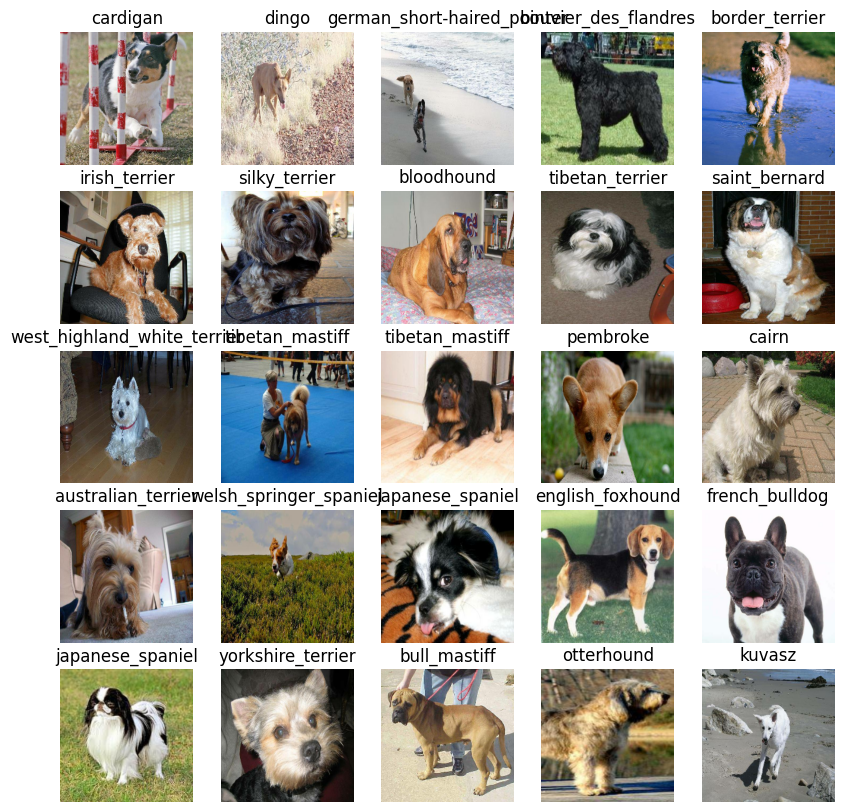

In [34]:
# Now let's visualize the images in a data batch
show_25_images(train_images, train_labels)

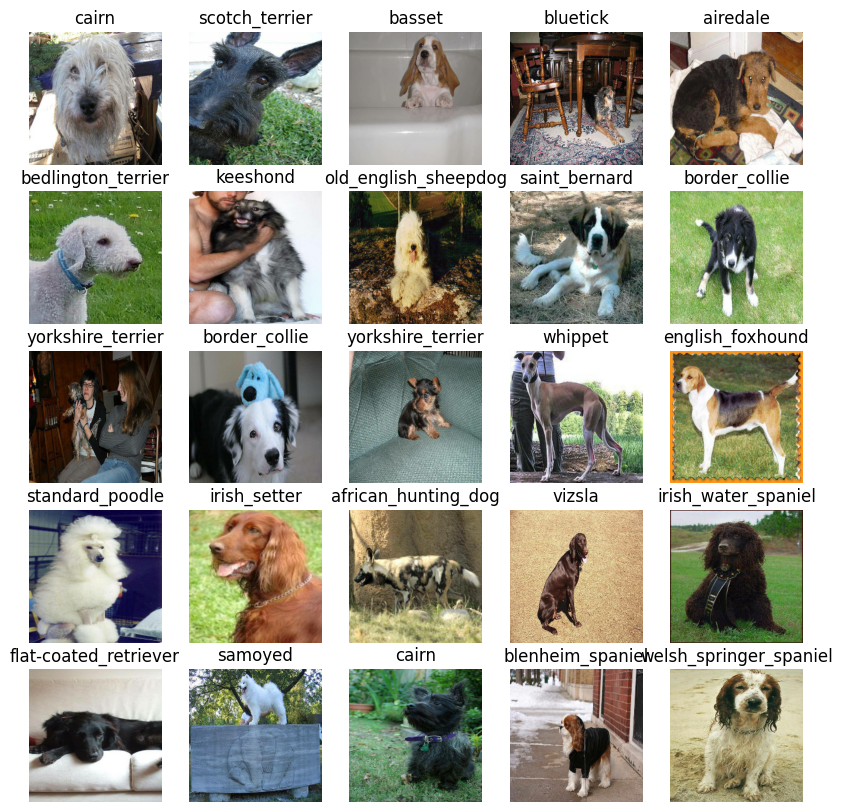

In [35]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a Model

Before we build a model, there are a few things we need to define:
* The input shape(our images shape, in the form of Tensors) to our model
* The output shape(the image labels, in the form of Tensors) of our model
* The URL of the model we want to use from tensorflow hub

In [36]:
# set up input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channel
OUTPUT_SHAPE = len(unique_breeds)

# set up model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our inputs, outputs and model ready to go. Let's put them together in a Keras deep learning model.

Knowing this, let's create a function which:
* Takes the input shape, output shape and model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion(do this first, then this, then that).
* Compiles the model(says how it should be evaluated and improved)
* Builds the model(tells the model the input shape it'll be getting).
* Returns the model

In [37]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with: ", MODEL_URL)
  # set up the model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # layer 1, input layer
      tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # layer 2 output layer
  ])

  # compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )
  # build the model
  model.build(INPUT_SHAPE)

  return model

In [38]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


**If we're doing binary classification, the `activation` is sigmoid and the loss is Binary Crossentropy. If we're doing multiclass classification, the `activation` is softmax and the loss is Categorical Crossentropy.**

## Creating callbacks

Callbacks are helper functions a model can use during training to do things such as save its progress, check its progress or stop training early if a model stops improving.

We'll create two cllbacks:
* one for tensorboard, which checks our model's progress.
* one for early stopping which prevents our model from training for too long.

To setup a tensorboard callback, we need to do 3 things:
1. Load the tensorboard notebook extension
2. Create a tensorboard callback which is able to save logs to a directory and pass it to our model's fit function.
3. Visualize our model's training logs with Tensorboard magic fuction.

### TensorBoard Callback

In [39]:
# Load tensorboard notebook extension
%load_ext tensorboard

In [40]:
import datetime

# create a function to build a tensorboard callback
def create_tensorboard_callback():
  # create log directory for storing tensorboard logs
  logdir = os.path.join("drive/MyDrive/Dog Vision/Logs",
                        # make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain metric has stopped improving.

In [41]:
# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

## Training a Model(on a subset of data)

Our first model is only going to train on 1000 images to make sure everything is working

In [42]:
NUM_EPOCHS= 100 #@param {type:"slider", min:10, max:100, step:10}

Let's create a function which trains a model
* create a model using `create_model()`
* setup a Tensorboard callback using `create_tensorboard_callback()`
* call the fit function on our model passing it the training data, validation data, number of epochs to train for, callbacks, return the model

In [43]:
# build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """

  # create a model
  model = create_model()

  # create new tensorboard session everytime you train a model
  tensorboard = create_tensorboard_callback()

  # fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # return the fitted model
  return model

In [44]:
# fit the model to the data
model = train_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 138s 5s/step - loss: 4.5853 - accuracy: 0.1063 - val_loss: 3.4368 - val_accuracy: 0.2750
Epoch 2/100
25/25 [==============================] - 3s 122ms/step - loss: 1.6665 - accuracy: 0.6687 - val_loss: 2.1717 - val_accuracy: 0.4700
Epoch 3/100
25/25 [==============================] - 4s 146ms/step - loss: 0.5703 - accuracy: 0.9425 - val_loss: 1.6707 - val_accuracy: 0.5700
Epoch 4/100
25/25 [==============================] - 5s 191ms/step - loss: 0.2505 - accuracy: 0.9925 - val_loss: 1.4737 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 3s 120ms/step - loss: 0.1450 - accuracy: 0.9987 - val_loss: 1.3885 - val_accuracy: 0.6200
Epoch 6/100
25/25 [==============================] - 3s 120ms/step - loss: 0.0987 - accuracy: 1.0000 - val_loss: 1.3416 - val_accuracy: 0.6250
Epoch 7/100
25/25 [==============================

### Checking the TensorBoard Logs

The TensorBoard magic function will access the logs diectory we created earlier and visualize its content.

In [45]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision/Logs

<IPython.core.display.Javascript object>

I don't know why it's showing a google 403 error. I tried searching for a solution, but could not find any. You can search again at another time.

## Making and Evaluating Predictions using a Trained Model

In [46]:
# make predictions on the validation data(not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 2s 93ms/step


array([[1.3627437e-03, 6.6875451e-05, 4.9032539e-04, ..., 2.6714784e-04,
        1.3718269e-05, 6.2231668e-03],
       [8.5845506e-03, 8.7096443e-04, 2.4840280e-03, ..., 3.1756796e-04,
        2.4527432e-03, 2.7340418e-05],
       [1.9572801e-06, 8.5482570e-06, 3.0564119e-05, ..., 1.3213235e-05,
        7.3168039e-06, 1.5027038e-04],
       ...,
       [1.1310877e-05, 6.3492858e-05, 6.4437518e-05, ..., 6.0543094e-05,
        8.2555373e-05, 6.8319445e-05],
       [1.3333550e-03, 3.0025429e-04, 9.2769231e-05, ..., 3.1916228e-05,
        7.6438700e-06, 3.9531835e-03],
       [5.4863984e-05, 4.3768337e-05, 4.0585492e-03, ..., 1.7421391e-02,
        4.8804973e-04, 3.0730269e-05]], dtype=float32)

In [47]:
predictions.shape

(200, 120)

In [48]:
# First prediction
print(predictions[0])
print(f"Max Value probability: ", {np.max(predictions[0])})
print(f"Predicted label: " ,{unique_breeds[np.argmax(predictions[0])]})

[1.36274367e-03 6.68754510e-05 4.90325387e-04 1.17613068e-04
 6.01019303e-04 6.22092339e-05 8.77857115e-03 1.84324896e-03
 1.65904421e-04 3.06226220e-03 1.57519797e-04 3.86085085e-05
 5.80663444e-04 1.45691709e-04 5.43565584e-05 2.25830983e-04
 3.11354379e-05 1.09679043e-01 7.84769327e-06 4.65966077e-05
 4.47175174e-04 3.84428655e-04 1.71304637e-05 1.69745227e-03
 4.24513782e-05 6.62377453e-04 2.43604556e-01 1.65141522e-04
 2.76619074e-04 2.29887271e-04 2.06909885e-04 2.11270689e-03
 4.66204388e-03 3.82180542e-06 5.48740718e-05 1.46879992e-02
 1.75589903e-05 9.95300798e-05 8.24117233e-05 9.09573864e-05
 1.02599303e-03 7.15042625e-05 4.48586870e-05 3.22145315e-05
 1.70837538e-05 8.25038878e-05 1.62076012e-05 4.35106704e-05
 2.55290244e-04 7.07086947e-05 7.42368691e-04 6.98677250e-05
 2.18100016e-04 6.46313201e-05 3.86660686e-05 5.89188603e-05
 8.80569132e-05 3.05301696e-03 6.46073197e-04 2.97240436e-01
 8.47631600e-05 6.09841845e-05 1.29051961e-03 2.64525697e-05
 2.71716068e-04 4.868533

In [49]:
# Turn prediction probabilities into their respective label
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into labels
  """

  return unique_breeds[np.argmax(prediction_probabilities)]

# get a prediction label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'irish_wolfhound'

Now since our validation data is in a batch dataset, we have to unbatchify it

In [50]:
# create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batch dataset of (image, label) Tensors and returns separate arrays of images and labels
  """
  images=[]
  labels=[]

  # loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

In [51]:
# unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [52]:
get_pred_label(val_labels[0])

'affenpinscher'

Let's make a functions to make all these predictions for visual

In [53]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction ,ground truth and image for sample n
  """
  pred_prob, true_label, image=prediction_probabilities[n], labels[n], images[n]
  # get the pred label
  pred_label = get_pred_label(pred_prob)

  # plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # change the colour of the title depending on if the prediction is right or wrong
  if pred_label==true_label:
    color="green"
  else:
    color="red"
  # change plot title to predicted, probability of prediction and truth label
  plt.title("{} {:.2f} {}".format(pred_label,
                                  np.max(pred_prob)*100,
                                  true_label,),color=color)


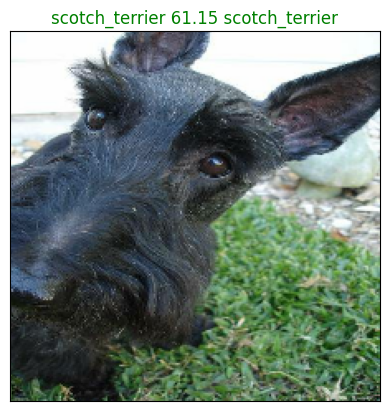

In [54]:
plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images, n=1)

### plotting the top 10 predictions of an image

In [55]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 prediction confidences along with the true labels for sample n
  """

  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # get the predicted label
  pred_label = get_pred_label(pred_prob)

  # find the top 10 prediction confidences indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels== true_label)].set_color("green")
  else:
    pass

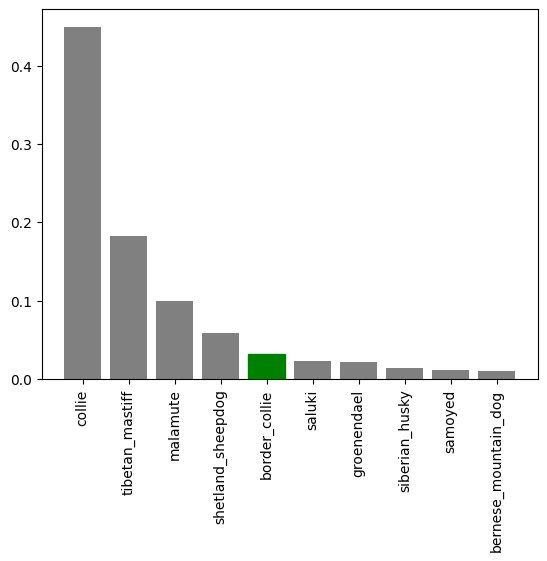

In [56]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

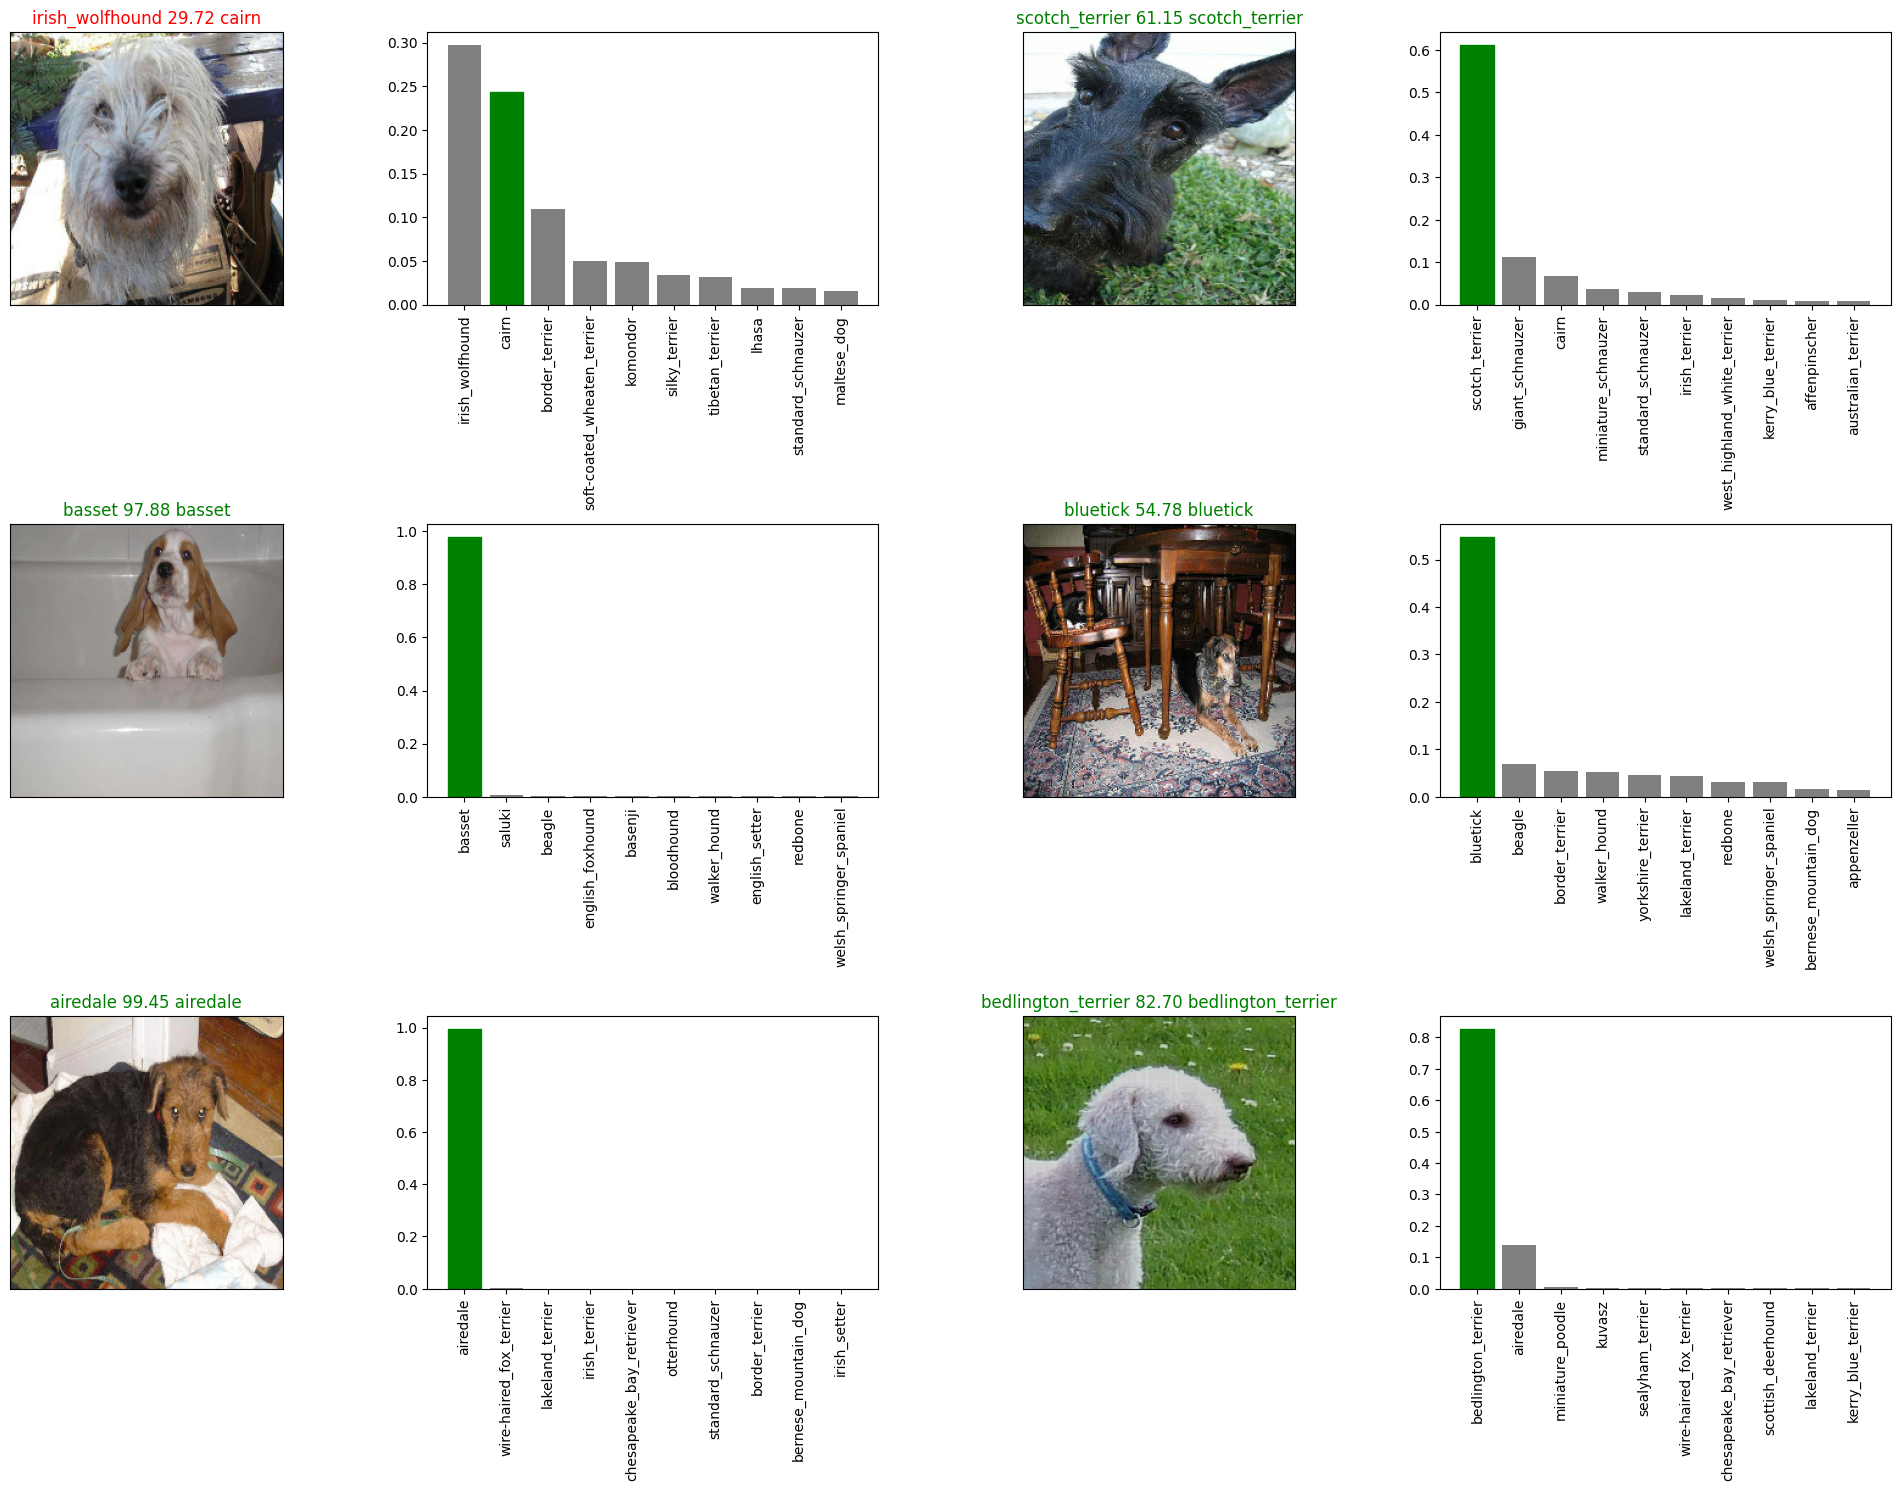

In [57]:
i_multiplier=0
num_rows=3
num_cols=2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [58]:
# create a function to save a model
def save_model(model, suffix=None):
  """
  saves a model in a model directory and appends a suffix(string)
  """

  # create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Dog Vision/Models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [59]:
# create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from specified path
  """

  print(f"Loading saved model from: {model_path}...")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer": hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model. Let's make sure they work

In [60]:
# save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog Vision/Models/20230825-080020-1000-images-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog Vision/Models/20230825-080020-1000-images-mobilenetv2-Adam.h5'

In [61]:
# load a trained model
loaded_1000_image_model = load_model("drive/MyDrive/Dog Vision/Models/20230824-150532-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Dog Vision/Models/20230824-150532-1000-images-mobilenetv2-Adam.h5...


In [62]:
# evaluate the presaved model
model.evaluate(val_data)

7/7 [==============================] - 1s 87ms/step - loss: 1.1859 - accuracy: 0.7000


[1.185907244682312, 0.699999988079071]

In [63]:
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 90ms/step - loss: 1.2092 - accuracy: 0.7000


[1.209172248840332, 0.699999988079071]

## Training a Big Dawg Model(on the full data)

In [64]:
# create a data batch with the full dataset
full_data = create_data_batches(X,y)

Creating training data batches...


In [65]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [66]:
# create a model for full data
full_model = create_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [67]:
# create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
#no validation set when training on all the data, so we can't monitor val accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

Running the cell will take a little while

In [68]:
# fit the full model to the full data
full_model.fit(x=full_data, epochs=NUM_EPOCHS, callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 40s 114ms/step - loss: 1.3496 - accuracy: 0.6677
Epoch 2/100
320/320 [==============================] - 36s 113ms/step - loss: 0.3996 - accuracy: 0.8833
Epoch 3/100
320/320 [==============================] - 34s 105ms/step - loss: 0.2371 - accuracy: 0.9320
Epoch 4/100
320/320 [==============================] - 35s 109ms/step - loss: 0.1523 - accuracy: 0.9647
Epoch 5/100
320/320 [==============================] - 35s 108ms/step - loss: 0.1054 - accuracy: 0.9805
Epoch 6/100
320/320 [==============================] - 34s 107ms/step - loss: 0.0764 - accuracy: 0.9873
Epoch 7/100
320/320 [==============================] - 34s 106ms/step - loss: 0.0603 - accuracy: 0.9914
Epoch 8/100
320/320 [==============================] - 34s 106ms/step - loss: 0.0458 - accuracy: 0.9936
Epoch 9/100
320/320 [==============================] - 36s 111ms/step - loss: 0.0378 - accuracy: 0.9963
Epoch 10/100
320/320 [==============================] - 34s 105m

In [69]:
save_model(model, suffix="full-image-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog Vision/Models/20230825-081400-full-image-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog Vision/Models/20230825-081400-full-image-mobilenetv2-Adam.h5'

In [71]:
loaded_full_model = load_model("drive/MyDrive/Dog Vision/Models/20230825-081400-full-image-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Dog Vision/Models/20230825-081400-full-image-mobilenetv2-Adam.h5...


## Making Predictions on Test Dataset

Since our model has been trained on images in the form of tensor batches, we need to get the test data in the same format in order to make predictions on it

In [72]:
# load test image filenames
test_path = "drive/MyDrive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]


In [73]:
# create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [75]:
# make predictions on test data batch using the loaded full model
#test_predictions = loaded_full_model.predict(test_data, verbose=1)

In [76]:
# save predictions to csv file for accessing  later
# no need to run the cell above if it takes too long. Just use the csv file i downloaded
#np.savetxt("drive/MyDrive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [77]:
# load predictions from csv file
test_predictions = np.loadtxt("drive/MyDrive/Dog Vision/preds_array.csv", delimiter=",")

## Making Predictions on Custom Images


To make predictions on custom images, we'll:
* Get the file paths of our own images
* Turn the filepaths into data batches using `create_data_batches`
* pass the custom image data batch to our model's predict method
* convert the prediction output probabilities to labels
* compare the labels to custom images

In [78]:
# get custom image filepaths
custom_path = "drive/MyDrive/Dog Vision/custom_dog_pics/"
custom_image_paths = [custom_path+ fname for fname in os.listdir(custom_path)]

In [79]:
custom_image_paths[:10]

['drive/MyDrive/Dog Vision/custom_dog_pics/basset1.jpeg',
 'drive/MyDrive/Dog Vision/custom_dog_pics/basset2.jpeg',
 'drive/MyDrive/Dog Vision/custom_dog_pics/basset3.jpeg',
 'drive/MyDrive/Dog Vision/custom_dog_pics/boston_terrier1.jpeg',
 'drive/MyDrive/Dog Vision/custom_dog_pics/boston_terrier2.jpeg',
 'drive/MyDrive/Dog Vision/custom_dog_pics/bull_mastiff.jpeg',
 'drive/MyDrive/Dog Vision/custom_dog_pics/cairn1.jpeg',
 'drive/MyDrive/Dog Vision/custom_dog_pics/collie1.jpeg',
 'drive/MyDrive/Dog Vision/custom_dog_pics/cairn2.jpeg',
 'drive/MyDrive/Dog Vision/custom_dog_pics/collie2.jpeg']

In [80]:
# turn custom images into batch dataset
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [81]:
# make predictions on custom data
custom_preds = loaded_full_model.predict(custom_data)
custom_preds

1/1 [==============================] - 1s 912ms/step


array([[3.6586320e-05, 1.6274759e-04, 3.1252080e-04, ..., 3.1248252e-05,
        4.5764382e-04, 2.2223986e-04],
       [2.6451291e-05, 1.5248562e-03, 1.8585240e-04, ..., 2.2386494e-01,
        2.6439743e-03, 4.8572605e-04],
       [4.5440710e-04, 1.8387086e-04, 1.3543727e-04, ..., 3.3885954e-04,
        3.7974415e-03, 3.4962676e-04],
       ...,
       [1.3687678e-05, 1.5080302e-03, 6.9340682e-03, ..., 1.2936711e-01,
        7.8776695e-02, 1.9457750e-05],
       [2.7880960e-03, 2.5240195e-03, 2.5607162e-04, ..., 9.0253714e-05,
        1.0984211e-03, 1.6543492e-04],
       [1.9061108e-05, 7.5113932e-03, 2.0598967e-05, ..., 1.8934890e-04,
        1.3155846e-05, 2.2639146e-03]], dtype=float32)

In [82]:
custom_preds.shape

(15, 120)

In [83]:
# get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['basset',
 'whippet',
 'basset',
 'boston_bull',
 'boston_bull',
 'bull_mastiff',
 'scotch_terrier',
 'collie',
 'west_highland_white_terrier',
 'border_collie',
 'dingo',
 'walker_hound',
 'saluki',
 'miniature_poodle',
 'toy_poodle']

In [84]:
custom_images=[]
# loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

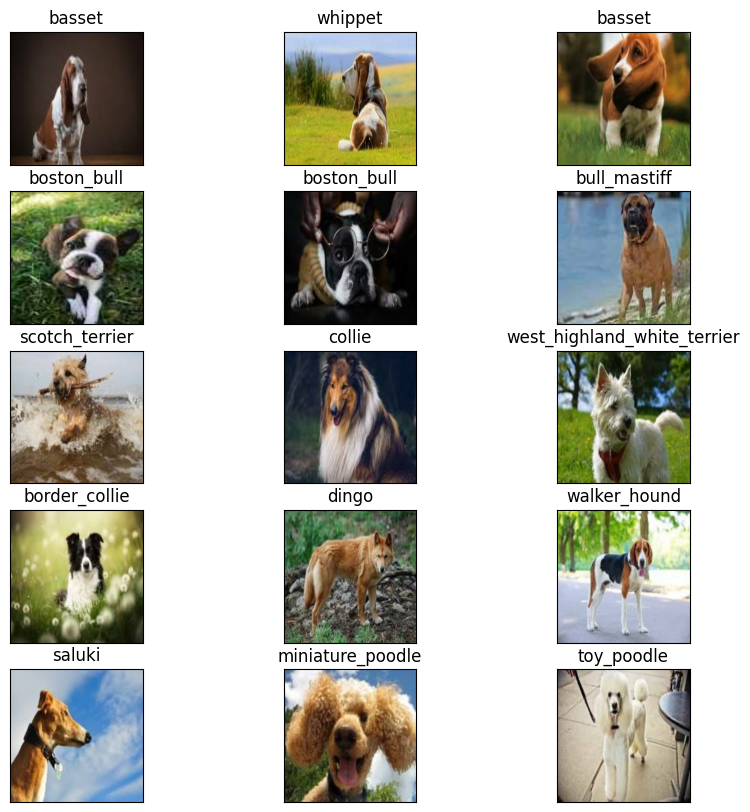

In [87]:
# check custom image predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(5, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)